<a href="https://colab.research.google.com/github/harika373/instagram-twitter-sentiment-Analysis/blob/main/instagram-twitter-sentiment-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Sentiment Analysis on Twitter + Play Store Reviews
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:
## 1. Load Datasets

In [6]:
twitter_df = pd.read_csv("/content/Twitter_Data.csv")         # Twitter dataset
playstore_df = pd.read_csv("/content/instagram.csv")       # Instagram reviews dataset

print("Twitter dataset shape:", twitter_df.shape)
print("PlayStore dataset shape:", playstore_df.shape)


Twitter dataset shape: (162980, 2)
PlayStore dataset shape: (210542, 3)


In [7]:
## 2. Preprocessing Function

In [8]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)    # Remove URLs
    text = re.sub(r"@[A-Za-z0-9_]+","", text)     # Remove mentions
    text = re.sub(r"#[A-Za-z0-9_]+","", text)     # Remove hashtags
    text = re.sub(r"[^a-z\s]", "", text)          # Remove punctuation/numbers
    return text.strip()


In [10]:
# Clean both datasets
twitter_df['clean_text'] = twitter_df['clean_text'].apply(clean_text)

In [12]:
# Some Play Store datasets don’t have sentiment column, only ratings.
# If so, map ratings to sentiment (adjust as per your dataset).
if 'sentiment' not in playstore_df.columns and 'rating' in playstore_df.columns:
    def rating_to_sentiment(rating):
        if rating >= 4:
            return "positive"
        elif rating == 3:
            return "neutral"
        else:
            return "negative"
    playstore_df['sentiment'] = playstore_df['rating'].apply(rating_to_sentiment)

playstore_df['clean_text'] = playstore_df['review_description'].apply(clean_text)

In [13]:
## 3. Prepare Labels

In [15]:
twitter_df = twitter_df[['clean_text', 'category']].rename(columns={'category': 'sentiment'})
playstore_df = playstore_df[['clean_text', 'sentiment']]

df = pd.concat([twitter_df, playstore_df], axis=0).dropna()
print("Final combined dataset:", df.shape)
print(df['sentiment'].value_counts())

Final combined dataset: (373515, 2)
sentiment
 negative    120550
 1.0          72250
 positive     63460
 0.0          55213
-1.0          35510
 neutral      26532
Name: count, dtype: int64


In [16]:
## 4. Train-Test Split

In [18]:
X = df['clean_text']
y = df['sentiment'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
## 5. TF-IDF Vectorization

In [20]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [21]:
## 6. Train Models

In [22]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))


Logistic Regression Results:
Accuracy: 0.8220285664565011
              precision    recall  f1-score   support

        -1.0       0.89      0.74      0.81      7102
         0.0       0.85      0.97      0.91     11043
         1.0       0.92      0.90      0.91     14450
    negative       0.78      0.94      0.85     24110
     neutral       0.37      0.06      0.11      5306
    positive       0.79      0.75      0.77     12692

    accuracy                           0.82     74703
   macro avg       0.76      0.73      0.72     74703
weighted avg       0.80      0.82      0.80     74703


Naive Bayes Results:
Accuracy: 0.7433971861906483
              precision    recall  f1-score   support

        -1.0       0.89      0.38      0.54      7102
         0.0       0.83      0.70      0.75     11043
         1.0       0.67      0.92      0.77     14450
    negative       0.74      0.95      0.83     24110
     neutral       0.42      0.01      0.02      5306
    positive       0.7

In [23]:
##7. Visualization

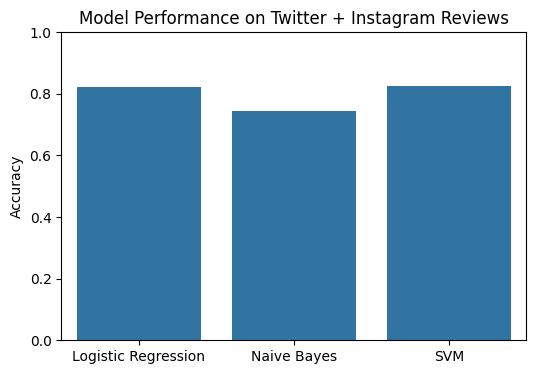

In [24]:
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Performance on Twitter + Instagram Reviews")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

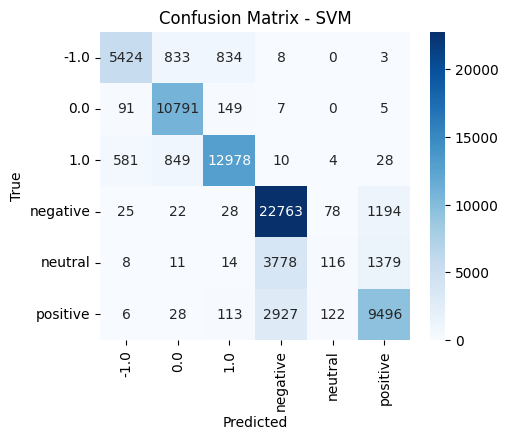

In [25]:
# Confusion Matrix for Best Model
best_model = max(results, key=results.get)
y_pred_best = models[best_model].predict(X_test_vec)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f"Confusion Matrix - {best_model}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()